# **Exploratory Data Analysis**: FlipTop

## Question
----

The central question of this project revolves around FlipTop battle rap careers and their length.

> How long does a career in the Philippines' premier rap battle league FlipTop last?

Who rises to the top? What determines who stays relevant over the years?

Here I'm thinking survival (time-to-event) analysis.

Another question I'm curious about is this:
> Who has battled who? And what matchups haven't been done yet?

I'm picturing a graph here. I want to understand how dense or sparse the network of rap battles are in FlipTop.

Ideas:
- Emcees are nodes
- "Battled" as edges
- Weight of the edge is how many times they've battled?

## Data Wrangling
----

Data wrangled using [YouTube API](https://developers.google.com/youtube/v3).

In [1]:
import sys
import json
import pandas as pd
import numpy as np
import isodate
import re

Note: This data was scraped July 2, 2025.
- Update: Channel data was scraped again August 26, 2025.

In [ ]:
# Load JSON data
with open("../data/videos.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Preview
df.head()

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02T13:23:54Z,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb..."
1,JabvhPBmoVs,FlipTop CripLi - Isabuhay 2025 | Abangan si Cr...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,27498,PT1M51S,https://www.youtube.com/watch?v=JabvhPBmoVs,640,31,"[fliptop, flip top, flip top battles, fliptopb..."
2,YiJI_ohq4Pc,FlipTop Ban - Isabuhay 2025 | Abangan si Ban n...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,29353,PT1M24S,https://www.youtube.com/watch?v=YiJI_ohq4Pc,763,34,"[fliptop, flip top, flip top battles, fliptopb..."
3,yRE3PU0ekaA,FlipTop J-Blaque - Gods Pa Rin? | | Abangan si...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,17415,PT1M56S,https://www.youtube.com/watch?v=yRE3PU0ekaA,360,8,"[fliptop, flip top, flip top battles, fliptopb..."
4,Ftk2DZ3hcxw,FlipTop Vitrum - Ang HipHop Pinalakas ng mga T...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:48:58Z,28969,PT3M15S,https://www.youtube.com/watch?v=Ftk2DZ3hcxw,449,50,"[fliptop, flip top, flip top battles, fliptopb..."


In [3]:
# No need to run this again (already ran once and wrote to file)
sys.path.append("../scripts")

from emcee_scraper import scrape_names, write_names_to_csv
emcees = scrape_names()
write_names_to_csv(emcees, "../data/emcees.csv")

Scraped 20 names from page 1.
Scraped 20 names from page 2.
Scraped 20 names from page 3.
Scraped 20 names from page 4.
Scraped 20 names from page 5.
Scraped 20 names from page 6.
Scraped 20 names from page 7.
Scraped 20 names from page 8.
Scraped 12 names from page 9.
No emcees found on page 10. Stopping early.
Wrote 172 names to ../data/emcees.csv


## Data Cleaning
----

Tasks:

- convert `upload_date` to something more usable.
- convert `duration` to human readable (HH:MM:SS maybe?)
- Some shorts/round highlight moments were uploaded on the [videos playlist](https://www.youtube.com/@fliptopbattles/videos) of the channel so need to filter by duration, especially post-2020 (when YouTube Shorts became a thing).
- Only considering 1v1 battles that were judged (for now)
    - So remove:
        - Sound Check
        - Freestyle battles
        - Dos Por Dos (2v2)
        - Royal Rumble (1v1v1v1v1)
        - Those two 5v5 battles that happened only twice
        - Anygma Machine
        - Video Flyer
        - Announcement videos
        - Emcee interview videos

BIG TASKS

- Clean up `title` and create new column `battle_card` or something that contains only names e.g. Emcee1 vs Emcee2
- Webscrape [emcee page](https://www.fliptop.com.ph/emcees) to get a full and complete list of the emcees in FlipTop (according to their own website roster).
    - Good for later user of cross-referencing titles with emcee names.
- 

In [4]:
df.head()

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02T13:23:54Z,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb..."
1,JabvhPBmoVs,FlipTop CripLi - Isabuhay 2025 | Abangan si Cr...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,27498,PT1M51S,https://www.youtube.com/watch?v=JabvhPBmoVs,640,31,"[fliptop, flip top, flip top battles, fliptopb..."
2,YiJI_ohq4Pc,FlipTop Ban - Isabuhay 2025 | Abangan si Ban n...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,29353,PT1M24S,https://www.youtube.com/watch?v=YiJI_ohq4Pc,763,34,"[fliptop, flip top, flip top battles, fliptopb..."
3,yRE3PU0ekaA,FlipTop J-Blaque - Gods Pa Rin? | | Abangan si...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,17415,PT1M56S,https://www.youtube.com/watch?v=yRE3PU0ekaA,360,8,"[fliptop, flip top, flip top battles, fliptopb..."
4,Ftk2DZ3hcxw,FlipTop Vitrum - Ang HipHop Pinalakas ng mga T...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:48:58Z,28969,PT3M15S,https://www.youtube.com/watch?v=Ftk2DZ3hcxw,449,50,"[fliptop, flip top, flip top battles, fliptopb..."


In [5]:
# looking at desc
samp = df.sample(n=5, replace=False)
samp

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags
342,hSFlYfrX9Hw,FlipTop Sound Check - Second Sight 11,FlipTop presents: Second Sight 11 @ TIU Theate...,2023-04-10T10:24:41Z,131198,PT15M57S,https://www.youtube.com/watch?v=hSFlYfrX9Hw,2825,346,"[fliptop, flip top, flip top battles, fliptopb..."
446,LLPnSbMO9Vw,FlipTop - Harlem vs MastaFeat,"FlipTop presents: Ahon 12 @ D' mention, Buhay ...",2022-02-25T12:44:04Z,1143972,PT40M8S,https://www.youtube.com/watch?v=LLPnSbMO9Vw,17206,1569,"[fliptop, flip top, flip top battles, fliptopb..."
1295,odPvGpKNB_8,FlipTop - Range vs Zeus,FlipTop Visayas presents: Gubat II @ CAP Cente...,2015-01-22T10:02:03Z,182692,PT15M20S,https://www.youtube.com/watch?v=odPvGpKNB_8,386,129,"[range, zeus, fliptop, fliptop new, fliptop la..."
503,0_C0HO-EXLY,FlipTop - Goriong Talas vs Vitrum @ Isabuhay 2021,FlipTop presents: Bwelta Balentong 8 @ D' ment...,2021-07-01T12:03:40Z,404268,PT28M4S,https://www.youtube.com/watch?v=0_C0HO-EXLY,6756,1480,"[fliptop, flip top, flip top battles, fliptopb..."
517,CQ6D-hee5Qw,Tres Diablos [LIVE] @ The FlipTop Festival 2020,*BEST LISTENED TO ON SPEAKER OR HEAD PHONES*\n...,2021-05-14T13:15:17Z,14048,PT7M46S,https://www.youtube.com/watch?v=CQ6D-hee5Qw,330,57,"[fliptop, flip top, flip top battles, fliptopb..."


In [6]:
samp["description"]

342     FlipTop presents: Second Sight 11 @ TIU Theate...
446     FlipTop presents: Ahon 12 @ D' mention, Buhay ...
1295    FlipTop Visayas presents: Gubat II @ CAP Cente...
503     FlipTop presents: Bwelta Balentong 8 @ D' ment...
517     *BEST LISTENED TO ON SPEAKER OR HEAD PHONES*\n...
Name: description, dtype: object

In [7]:
# Write multi-line descriptions to file for analysis
title_desc = samp[["title", "description"]]
records = title_desc.to_dict(orient="records")

with open("../data/sample_descriptions.json", "w", encoding="utf-8") as f:
    json.dump(records, f, indent=2, ensure_ascii=False)

In [8]:
with open("../data/sample_descriptions.json", "r", encoding="utf-8") as f:
    descriptions = json.load(f)

# Pick the first one (index 0) or whichever index you want
sample = descriptions[1]

# Print nicely
print("TITLE:\n", sample["title"])
print("\nDESCRIPTION:\n", sample["description"])

TITLE:
 FlipTop - Harlem vs MastaFeat

DESCRIPTION:
 FlipTop presents: Ahon 12 @ D' mention, Buhay Parin City, Metro Manila, Philippines. December 2021. Filipino Conference Battle.

-HARLEM VS MASTAFEAT-

Subscribe Here! http://bit.ly/fliptopsub
Check out our top videos! http://bit.ly/fliptopTopVideos

Facebook: https://www.facebook.com/fliptop.battleleague
Instagram: https://instagram.com/fliptopbattles
Twitter: https://twitter.com/FlipTop_Battles
Patreon: https://patreon.com/fliptop
For Sponsorship: Email partner@fliptop.com.ph 

#Harlem #MastaFeat #Ahon12 

About fliptopbattles:
FlipTop Kru Corp. is a self-produced events and artist management company with its first product in the FlipTop Battle League. The FlipTop Battle League is the Philippines’ first premier – and the world’s most-viewed – rap battle league. It is popularly credited for the resurgence and widespread acceptance of hiphop culture in the Philippines since its inception in February 2010, and continues to champion al

Video descriptions often have good info on them for when and where the rap battle took place. Need to scrape these too!
- Let's put a pin on that right now. Do low-hanging fruit first before going for messy regex text extraction tasks.

In [9]:
df.head()

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02T13:23:54Z,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb..."
1,JabvhPBmoVs,FlipTop CripLi - Isabuhay 2025 | Abangan si Cr...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,27498,PT1M51S,https://www.youtube.com/watch?v=JabvhPBmoVs,640,31,"[fliptop, flip top, flip top battles, fliptopb..."
2,YiJI_ohq4Pc,FlipTop Ban - Isabuhay 2025 | Abangan si Ban n...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,29353,PT1M24S,https://www.youtube.com/watch?v=YiJI_ohq4Pc,763,34,"[fliptop, flip top, flip top battles, fliptopb..."
3,yRE3PU0ekaA,FlipTop J-Blaque - Gods Pa Rin? | | Abangan si...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:49:25Z,17415,PT1M56S,https://www.youtube.com/watch?v=yRE3PU0ekaA,360,8,"[fliptop, flip top, flip top battles, fliptopb..."
4,Ftk2DZ3hcxw,FlipTop Vitrum - Ang HipHop Pinalakas ng mga T...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25T13:48:58Z,28969,PT3M15S,https://www.youtube.com/watch?v=Ftk2DZ3hcxw,449,50,"[fliptop, flip top, flip top battles, fliptopb..."


In [10]:
# Convert to upload_date to datetime objects
df["upload_date"] = pd.to_datetime(df["upload_date"], utc=True)

# Create duration_timedelta col
df["duration_timedelta"] = df["duration"].apply(isodate.parse_duration)

# Create duration_seconds col (for ez calculations down the line)
df["duration_seconds"] = df["duration_timedelta"].dt.total_seconds()

In [11]:
df.head()

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:32,1952.0
1,JabvhPBmoVs,FlipTop CripLi - Isabuhay 2025 | Abangan si Cr...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25 13:49:25+00:00,27498,PT1M51S,https://www.youtube.com/watch?v=JabvhPBmoVs,640,31,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:01:51,111.0
2,YiJI_ohq4Pc,FlipTop Ban - Isabuhay 2025 | Abangan si Ban n...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25 13:49:25+00:00,29353,PT1M24S,https://www.youtube.com/watch?v=YiJI_ohq4Pc,763,34,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:01:24,84.0
3,yRE3PU0ekaA,FlipTop J-Blaque - Gods Pa Rin? | | Abangan si...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25 13:49:25+00:00,17415,PT1M56S,https://www.youtube.com/watch?v=yRE3PU0ekaA,360,8,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:01:56,116.0
4,Ftk2DZ3hcxw,FlipTop Vitrum - Ang HipHop Pinalakas ng mga T...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25 13:48:58+00:00,28969,PT3M15S,https://www.youtube.com/watch?v=Ftk2DZ3hcxw,449,50,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:03:15,195.0


Next task:
- Subset `df` to only include 1v1 battles.

While the majority of the videos posted on the [FlipTop YouTube channel](https://www.youtube.com/@fliptopbattles) are rap battles, a number of them are video flyers, announcement videos, behind-the-scenes content, reaction videos, and the like. As such, it's important to filter out these videos so that we're left to analyze the data from the **rap battles** alone.

### But what constitutes a **rap battle**?

Good question.

My criteria for what is considered a rap battle for the purposes of this project:
1. The video needs to be *a capella* (no underlying beat to accompany emcees rapping).
2. The video involves emcees performing written material (not all of their rounds are off-the-top freestyle). 
    - The early days of FlipTop saw emcees testing each other's skills in the artform known as off-the-top freestyle, where emcees would take turns berating each other lyrically with material they thought of on the spot or in the moment of speaking. 
3. To a lesser extent, the video needs to involve judging at the end (there needs to be stakes).

Note:
- **By these criteria, earlier videos of FlipTop wouldn't be included. Need explanation for what I'm doing here.**
    - I've changed my mind on this. I've included them alongside the freestyle battles whether a capella or with a beat.

As a long-time viewer of these videos, there's a couple key words that makes filtering with these criteria in mind easier. 
- Include:
    - **vs** - most, if not all, of the a capella rap battles in the FlipTop YouTube channel have "vs" in the video title. 
        - For the uninitiated: "vs" is short for "versus." 
- Exclude:
    - **tryout** - while these are battles, they are for the newcomers to the scene and is often not judged, especially in older videos.
    - **beatbox** - this is another genre of battle separate from the a capella, judged battles.
    - **flyer** and **promo** - these are advertisements and announcement videos for upcoming events.
    - **Anygma Machine** - Anygma, the head of FlipTop as a company, sometimes reviews battles and gives his take on upcoming matches.
        - A reference to the real [Enigma Machine](https://en.wikipedia.org/wiki/Enigma_machine) that the allies had to break in WW2.
   - **[LIVE]** - live performances from the FlipTop Festival event that happened in 2020.
   - **UnggoYan** - Emcees read comments left on videos of their previous battles
   - **Pre-Battle Interviews** - self-explanatory
   - **Salitang Ugat** - translation: "root word." These are interviews of notable emcees who tell the stories behind how they came up with their rap battle name.
   - **Trailer** - promo video trailer for upcomming events
   - **Video Flyer** - self-explanatory
   - **Silip** - BTS videos added recently
   - **Sound Check** - Pre-event check in with FlipTop event prep stuff
   - **Tribute** - tribute to dead rappers
   - **Tutok** - other BTS videos?
   - **Abangan** - clips

For the scope of this project, I will only consider the battles that are between two people. FlipTop has a variety of rap battle formats, not just two people insulting each other back and forth. Examples include: the Royal Rumble, the 5 vs 5, and the tag-team 2 vs 2 (Dos Por Dos) matches. The vast majority of the battles, though, are one versus one. Those battles will be the focus of this project.

In [12]:
df.head()

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:32,1952.0
1,JabvhPBmoVs,FlipTop CripLi - Isabuhay 2025 | Abangan si Cr...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25 13:49:25+00:00,27498,PT1M51S,https://www.youtube.com/watch?v=JabvhPBmoVs,640,31,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:01:51,111.0
2,YiJI_ohq4Pc,FlipTop Ban - Isabuhay 2025 | Abangan si Ban n...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25 13:49:25+00:00,29353,PT1M24S,https://www.youtube.com/watch?v=YiJI_ohq4Pc,763,34,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:01:24,84.0
3,yRE3PU0ekaA,FlipTop J-Blaque - Gods Pa Rin? | | Abangan si...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25 13:49:25+00:00,17415,PT1M56S,https://www.youtube.com/watch?v=yRE3PU0ekaA,360,8,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:01:56,116.0
4,Ftk2DZ3hcxw,FlipTop Vitrum - Ang HipHop Pinalakas ng mga T...,"FlipTop presents: Gubat 15 @ Mariner's Court, ...",2025-06-25 13:48:58+00:00,28969,PT3M15S,https://www.youtube.com/watch?v=Ftk2DZ3hcxw,449,50,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:03:15,195.0


In [13]:
df.shape

(1771, 12)

In [14]:
# Include if "vs" in the title
with_vs = df[df["title"].str.contains(r"\bvs\b", case=False, regex=True)]

# Key words and phrases to exclude
exclude_keywords = [
    "tryout", "tryouts", "beatbox", "beat box", "flyer", "promo", "promos", 
    "anygma machine", "unggoyan", "pre-battle interviews", "interview",
    "interviews", "salitang ugat", "trailer", "video flyer", "[live]",
    "silip", "sound check", "tribute", "anniversary party","tutok", "review",
    "abangan"
]

# Regex OR pattern to discard non-battles
exclude_pattern = "|".join([re.escape(word) for word in exclude_keywords])


df_f = with_vs[~with_vs["title"].str.contains(exclude_pattern, case=False, regex=True)]


In [15]:
df_f.shape

(1303, 12)

In [16]:
df_f.head()

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:32,1952.0
5,RDiDkJHcnqs,FlipTop - Negho Gy vs Hespero,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-06-25 12:44:16+00:00,334399,PT32M9S,https://www.youtube.com/watch?v=RDiDkJHcnqs,4636,764,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:09,1929.0
6,9xWuT-atbuo,FlipTop - Yagi vs JP,"FlipTop presents: Pakusganay 8 @ Davao City, M...",2025-03-24 12:51:25+00:00,157503,PT38M52S,https://www.youtube.com/watch?v=9xWuT-atbuo,3078,904,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:38:52,2332.0
7,UfFT7TbtRy0,FlipTop - No. 144 vs Markong Bungo,FlipTop presents: Second Sight 13 @ TIU Theate...,2024-12-04 12:45:47+00:00,744384,PT26M,https://www.youtube.com/watch?v=UfFT7TbtRy0,15920,2717,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:26:00,1560.0
8,zWTapWo_Iho,FlipTop - Shaboy vs Marichu,FlipTop presents: Won Minutes Luzon 2 @ 88Fry...,2024-08-03 09:58:17+00:00,294043,PT13M50S,https://www.youtube.com/watch?v=zWTapWo_Iho,4583,689,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:13:50,830.0


I still see non-battles from the titles. Need to inspect all titles from `df_f`.

In [17]:
# Inspection
import os
os.makedirs("../data", exist_ok=True)
df_f[["title"]].to_csv("../data/to_filter.csv", index=False)

In [18]:
df_f.head()

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:32,1952.0
5,RDiDkJHcnqs,FlipTop - Negho Gy vs Hespero,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-06-25 12:44:16+00:00,334399,PT32M9S,https://www.youtube.com/watch?v=RDiDkJHcnqs,4636,764,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:09,1929.0
6,9xWuT-atbuo,FlipTop - Yagi vs JP,"FlipTop presents: Pakusganay 8 @ Davao City, M...",2025-03-24 12:51:25+00:00,157503,PT38M52S,https://www.youtube.com/watch?v=9xWuT-atbuo,3078,904,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:38:52,2332.0
7,UfFT7TbtRy0,FlipTop - No. 144 vs Markong Bungo,FlipTop presents: Second Sight 13 @ TIU Theate...,2024-12-04 12:45:47+00:00,744384,PT26M,https://www.youtube.com/watch?v=UfFT7TbtRy0,15920,2717,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:26:00,1560.0
8,zWTapWo_Iho,FlipTop - Shaboy vs Marichu,FlipTop presents: Won Minutes Luzon 2 @ 88Fry...,2024-08-03 09:58:17+00:00,294043,PT13M50S,https://www.youtube.com/watch?v=zWTapWo_Iho,4583,689,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:13:50,830.0


Now it's time to include only 1v1 battles.

In [19]:
import re

def is_probably_not_1v1(title):
    if not isinstance(title, str):
        return True  # defensive: non-string, toss it

    title_lower = title.lower()

    # Heuristic 1: multiple "vs"
    if len(re.findall(r"\bvs\b", title_lower)) > 1:
        return True

    # Heuristic 2: "and" appears more than once (i.e., on both sides of the battle)
    if len(re.findall(r"\band\b", title_lower)) > 1:
        return True

    # Heuristic 3: slash (with or without spaces)
    if re.search(r"\s*/\s*|\s*/|\*/\s*", title_lower):
        return True

    # Heuristic 4: plus sign (no-shows)
    if "+" in title_lower:
        return True

    # Heuristic 5: common 2v2 pattern: "and" on both sides of "vs"
    if re.search(r"\band\b.*\bvs\b.*\band\b", title_lower):
        return True
    
    # Heuristic 6: team format like "5 on 5 battle"
    if re.search(r"\b\d+\s*on\s*\d+\b", title_lower):
        return True

    return False    

In [20]:
# Filtering
mask = df_f["title"].apply(is_probably_not_1v1)
df_not_1v1 = df_f[mask]         # Filtered out (bad) - inspect
df_1v1_only = df_f[~mask]       # Final 1v1 dataset? Pending inspection

In [21]:
# Audit output
print("Filtered out (not 1v1):")
for title in df_not_1v1["title"]:
    print("-", title)

Filtered out (not 1v1):
- FlipTop - Crazymix/Bassilyo vs Cripli/Towpher @ DosPorDos 2017
- FlipTop - Rapido/Icaruz vs Dopee/Snob @ Dos Por Dos 2
- FlipTop - CripLi / Towpher vs K-Ram / SlockOne
- FlipTop - Caspher / Hespero vs Atoms / Cygnus @ DosPorDos 2024 Finals
- FlipTop - Negho G / Pamoso vs Atoms / Cygnus @ DosPorDos 2024 Semifinals
- FlipTop - Caspher / Hespero vs Aubrey / Marichu @ DosPorDos 2024 Semifinals
- FlipTop - Negho Gy / Pamoso vs RG / Deadline @ DosPorDos2024
- FlipTop - Aubrey / Marichu vs Sickreto / Article Clipted @ DosPorDos2024
- FlipTop - Bisente / Jawz vs Atoms / Cygnus @ DosPorDos 2024
- FlipTop - Caspher / Hespero vs Kenzer / Mimack @ DosPorDos 2024
- FlipTop - Frooz / Elbiz vs Mac T / G-Spot
- FlipTop - Pistolero / Luxuria vs MastaFeat / Hearty | Surprise Freestyle Battle
- FlipTop - Sur Henyo vs Kregga vs Batang Rebelde vs LilStrocks vs Bagsik *ROYAL RUMBLE*
- FlipTop - K-Ram/SlockOne vs Vitrum/Illtimate
- FlipTop - Zaito vs C-Quence vs CNine vs Prince Rhym

In [22]:
df_not_1v1[["title"]].to_csv("../data/not_1v1_filtered_out.csv", index=False)

In [23]:
df_1v1_only.head(3)

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:32,1952.0
5,RDiDkJHcnqs,FlipTop - Negho Gy vs Hespero,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-06-25 12:44:16+00:00,334399,PT32M9S,https://www.youtube.com/watch?v=RDiDkJHcnqs,4636,764,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:09,1929.0
6,9xWuT-atbuo,FlipTop - Yagi vs JP,"FlipTop presents: Pakusganay 8 @ Davao City, M...",2025-03-24 12:51:25+00:00,157503,PT38M52S,https://www.youtube.com/watch?v=9xWuT-atbuo,3078,904,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:38:52,2332.0


In [24]:
df_1v1_only.shape

(1209, 12)

In [25]:
df_1v1_only.loc[:, "title"] = df_1v1_only["title"].str.strip()

In [26]:
# Strip leading and trailing " from title — only if they exist
df_1v1_only = df_1v1_only.copy()
df_1v1_only["title"] = df_1v1_only["title"].str.replace(r'^"(.*)"$', r'\1', regex=True)

In [27]:
df_1v1_only.shape

(1209, 12)

Need to inspect this 1v1 only df to see if it still contains non-1v1 battles

In [28]:
df_1v1_only[["title"]].to_csv("../data/filtered_1v1.tsv", sep="\t", index=False)

There are commas in 3 of the videos that are 1v1 battles. Writing to csv without specifying tab separated values instead puts "quotes" on those battles.
- Solved.

Looks all good on cursory inspection.

Next task: deal with early FlipTop battles having parts `pt. 1` and `pt. 2` etc.
- Make it into 1 video but now the links are a list instead of only string?

In [29]:
df_1v1_only.columns

Index(['id', 'title', 'description', 'upload_date', 'view_count', 'duration',
       'url', 'likeCount', 'commentCount', 'tags', 'duration_timedelta',
       'duration_seconds'],
      dtype='object')

In [30]:
df_1v1_only.dtypes

id                                 object
title                              object
description                        object
upload_date           datetime64[ns, UTC]
view_count                         object
duration                           object
url                                object
likeCount                          object
commentCount                       object
tags                               object
duration_timedelta        timedelta64[ns]
duration_seconds                  float64
dtype: object

In [31]:
# Convert some cols to numeric
df_1v1_only["view_count"] = pd.to_numeric(df_1v1_only["view_count"], errors="coerce")
df_1v1_only["likeCount"] = pd.to_numeric(df_1v1_only["likeCount"], errors="coerce")
df_1v1_only["commentCount"] = pd.to_numeric(df_1v1_only["commentCount"], errors="coerce")

In [32]:
df_1v1_only.head(5)

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:32,1952.0
5,RDiDkJHcnqs,FlipTop - Negho Gy vs Hespero,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-06-25 12:44:16+00:00,334399,PT32M9S,https://www.youtube.com/watch?v=RDiDkJHcnqs,4636,764,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:09,1929.0
6,9xWuT-atbuo,FlipTop - Yagi vs JP,"FlipTop presents: Pakusganay 8 @ Davao City, M...",2025-03-24 12:51:25+00:00,157503,PT38M52S,https://www.youtube.com/watch?v=9xWuT-atbuo,3078,904,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:38:52,2332.0
7,UfFT7TbtRy0,FlipTop - No. 144 vs Markong Bungo,FlipTop presents: Second Sight 13 @ TIU Theate...,2024-12-04 12:45:47+00:00,744384,PT26M,https://www.youtube.com/watch?v=UfFT7TbtRy0,15920,2717,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:26:00,1560.0
8,zWTapWo_Iho,FlipTop - Shaboy vs Marichu,FlipTop presents: Won Minutes Luzon 2 @ 88Fry...,2024-08-03 09:58:17+00:00,294043,PT13M50S,https://www.youtube.com/watch?v=zWTapWo_Iho,4583,689,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:13:50,830.0


In [33]:
with_parts = df_1v1_only.copy()

In [34]:
import pandas as pd
import re

def consolidate_battle_parts(df):
    """
    Consolidates FlipTop battles split into pt. 1 and pt. 2 into a single row.
    Keeps Part 1's description and metadata, sums counts, and merges URLs.
    """
    df = df.copy()

    # Convert relevant columns to numeric just in case
    df["view_count"] = pd.to_numeric(df["view_count"], errors="coerce").fillna(0).astype(int)
    df["likeCount"] = pd.to_numeric(df["likeCount"], errors="coerce").fillna(0).astype(int)
    df["commentCount"] = pd.to_numeric(df["commentCount"], errors="coerce").fillna(0).astype(int)

    # Helper to normalize titles to identify pairs
    def get_base_title(title):
        return re.sub(r'\s*pt\.?\s*[12]$', '', title.strip(), flags=re.IGNORECASE).strip()

    def seconds_to_iso8601_duration(seconds):
        seconds = int(round(seconds))  # Ensure integer
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        secs = seconds % 60

        duration_str = "PT"
        if hours:
            duration_str += f"{hours}H"
        if minutes:
            duration_str += f"{minutes}M"
        if secs or (not hours and not minutes):  # Avoid empty PT
            duration_str += f"{secs}S"
        return duration_str

    # Identify rows with "pt. 1" or "pt. 2"
    is_part = df["title"].str.contains(r'\spt\.?\s*[12]$', case=False, regex=True)
    part_df = df[is_part].copy()
    part_df["base_title"] = part_df["title"].apply(get_base_title)

    grouped = part_df.groupby("base_title")

    consolidated_rows = []
    seen_titles = set()

    for base_title, group in grouped:
        if len(group) != 2:
            continue  # Skip if not exactly two parts

        # Ensure pt. 1 comes first
        sorted_group = group.sort_values("title")
        part1 = sorted_group.iloc[0]
        part2 = sorted_group.iloc[1]

        total_seconds = part1["duration_seconds"] + part2["duration_seconds"]

        consolidated = {
            "title": base_title,
            "description": part1["description"],
            "upload_date": part1["upload_date"],
            "url": [part1["url"], part2["url"]],
            "view_count": part1["view_count"] + part2["view_count"],
            "likeCount": part1["likeCount"] + part2["likeCount"],
            "commentCount": part1["commentCount"] + part2["commentCount"],
            "tags": list(set((part1["tags"] or []) + (part2["tags"] or []))),
            "duration": seconds_to_iso8601_duration(total_seconds),
            "duration_seconds": total_seconds,
            "duration_timedelta": pd.to_timedelta(total_seconds, unit="s"),
            "id": [part1["id"], part2["id"]],
        }
        consolidated_rows.append(consolidated)
        seen_titles.update(group.index)

    # Build consolidated DataFrame
    consolidated_df = pd.DataFrame(consolidated_rows)

    # Keep all other rows (not part of pt. 1/pt. 2)
    remaining_df = df.drop(index=seen_titles)

    # Combine and return
    final_df = pd.concat([remaining_df, consolidated_df], ignore_index=True)
    return final_df


In [35]:
df_cleaned = consolidate_battle_parts(with_parts)

In [36]:
df_cleaned.columns

Index(['id', 'title', 'description', 'upload_date', 'view_count', 'duration',
       'url', 'likeCount', 'commentCount', 'tags', 'duration_timedelta',
       'duration_seconds'],
      dtype='object')

In [37]:
df_cleaned[["id", "title", "view_count", "duration", "upload_date", "description"]].to_csv("../data/inspect_df_cleaned.tsv", sep="\t", index=True)

In [38]:
df_cleaned.tail(20)

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds
1178,yJtQH7TFGgA,FlipTop - Sensei vs Andros,FlipTop presents: Zoning 19 @ The TakeOver Lou...,2025-07-31 12:33:04+00:00,129471,PT30M34S,https://www.youtube.com/watch?v=yJtQH7TFGgA,2007,328,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:30:34,1834.0
1179,xyN0_xpiqFc,FlipTop - Jawz vs Lord Manuel,FlipTop presents: Zoning 19 @ The TakeOver Lou...,2025-07-29 12:52:50+00:00,163200,PT33M42S,https://www.youtube.com/watch?v=xyN0_xpiqFc,2585,553,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:33:42,2022.0
1180,yUVSb5_jO84,FlipTop - BLZR vs Antonym,FlipTop presents: Zoning 19 @ The TakeOver Lou...,2025-07-24 12:29:05+00:00,206913,PT28M33S,https://www.youtube.com/watch?v=yUVSb5_jO84,3044,555,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:28:33,1713.0
1181,gVGHFF0L-4s,FlipTop - Shaboy vs Bisente,FlipTop presents: Zoning 19 @ The TakeOver Lou...,2025-07-22 12:15:50+00:00,234300,PT35M53S,https://www.youtube.com/watch?v=gVGHFF0L-4s,3150,862,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:35:53,2153.0
1182,KtE9zdjN6Q4,FlipTop - CNine vs Cygnus,FlipTop presents: Zoning 19 @ The TakeOver Lou...,2025-07-17 12:58:29+00:00,384242,PT35M51S,https://www.youtube.com/watch?v=KtE9zdjN6Q4,5207,765,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:35:51,2151.0
1183,JixEkkEOSHk,FlipTop - Philos vs Nathan,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-12 12:09:28+00:00,203193,PT35M9S,https://www.youtube.com/watch?v=JixEkkEOSHk,2704,523,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:35:09,2109.0
1184,KYLK5MzAopA,FlipTop - Marichu vs Blizzard,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-10 12:11:14+00:00,339914,PT30M50S,https://www.youtube.com/watch?v=KYLK5MzAopA,4248,765,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:30:50,1850.0
1185,4SbQCiMrVRM,FlipTop - Fernie vs Jamy Sykes,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-08 13:07:16+00:00,164653,PT28M50S,https://www.youtube.com/watch?v=4SbQCiMrVRM,2737,594,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:28:50,1730.0
1186,7rjqA-IWl_o,FlipTop - Pamoso vs Caytriyu,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-05 12:54:31+00:00,198833,PT31M4S,https://www.youtube.com/watch?v=7rjqA-IWl_o,2987,642,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:31:04,1864.0
1187,"[Tycr21-NO5s, c4W2A3GdtzM]",FlipTop - Batas vs Fuego,"FlipTop presents: Ahon @ Guerrilla Radio, Pasi...",2010-07-13 03:16:55+00:00,7506575,PT15M24S,"[https://www.youtube.com/watch?v=Tycr21-NO5s, ...",8341,6038,"[texasbattleleague, gotbeef, tasbattles, batas...",0 days 00:15:24,924.0


In [39]:
df_cleaned.dtypes

id                                 object
title                              object
description                        object
upload_date           datetime64[ns, UTC]
view_count                          int64
duration                           object
url                                object
likeCount                           int64
commentCount                        int64
tags                               object
duration_timedelta        timedelta64[ns]
duration_seconds                  float64
dtype: object

In [40]:
df_cleaned[["title"]].to_csv("../data/inspect_titles.tsv", sep="\t", index=False)

Looks good upon inspection. Battles with parts consolidated!

Next task: 
- Add matchup column e.g. Emcee1 vs Emcee2
- Add emcee1 column e.g. Loonie
- Add emcee2 column e.g. Tipsy D

In [41]:
df_cleaned.head(15)

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:32,1952.0
1,RDiDkJHcnqs,FlipTop - Negho Gy vs Hespero,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-06-25 12:44:16+00:00,334399,PT32M9S,https://www.youtube.com/watch?v=RDiDkJHcnqs,4636,764,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:09,1929.0
2,9xWuT-atbuo,FlipTop - Yagi vs JP,"FlipTop presents: Pakusganay 8 @ Davao City, M...",2025-03-24 12:51:25+00:00,157503,PT38M52S,https://www.youtube.com/watch?v=9xWuT-atbuo,3078,904,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:38:52,2332.0
3,UfFT7TbtRy0,FlipTop - No. 144 vs Markong Bungo,FlipTop presents: Second Sight 13 @ TIU Theate...,2024-12-04 12:45:47+00:00,744384,PT26M,https://www.youtube.com/watch?v=UfFT7TbtRy0,15920,2717,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:26:00,1560.0
4,zWTapWo_Iho,FlipTop - Shaboy vs Marichu,FlipTop presents: Won Minutes Luzon 2 @ 88Fry...,2024-08-03 09:58:17+00:00,294043,PT13M50S,https://www.youtube.com/watch?v=zWTapWo_Iho,4583,689,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:13:50,830.0
5,tSn0rQCC7uM,FlipTop - Sickreto vs Murdz,"FlipTop presents: Ahon 14, Day 2 @ TIU Theater...",2024-04-04 12:33:45+00:00,162762,PT29M24S,https://www.youtube.com/watch?v=tSn0rQCC7uM,2747,757,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:29:24,1764.0
6,tsEtOkvu4HM,FlipTop - Empithri vs Murdz,"FlipTop presents: Gubat 12, Day 1 @ Mariner's ...",2023-10-31 12:36:28+00:00,268396,PT28M30S,https://www.youtube.com/watch?v=tsEtOkvu4HM,3804,564,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:28:30,1710.0
7,LOzAhN92lo4,FlipTop - Pen Pluma vs GI,FlipTop presents: Gubat 11 @ Mandaue Sports Co...,2023-05-26 12:51:12+00:00,481978,PT28M48S,https://www.youtube.com/watch?v=LOzAhN92lo4,5700,803,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:28:48,1728.0
8,Y0hgfpGo3cE,FlipTop - Lhipkram vs J-King,"FlipTop presents: Zoning 15 @ TIU Theater, Mak...",2022-11-30 12:30:26+00:00,2542323,PT33M11S,https://www.youtube.com/watch?v=Y0hgfpGo3cE,35452,2707,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:33:11,1991.0
9,MfH1NaCu7Ps,FlipTop - Poison13 vs SlockOne @ Isabuhay 2022,FlipTop presents: Second Sight 10 @ TIU Theate...,2022-05-26 12:58:20+00:00,2384593,PT32M1S,https://www.youtube.com/watch?v=MfH1NaCu7Ps,39388,2277,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:01,1921.0


In [42]:
def extract_matchup(title):
    match = re.search(r'-\s*(.*?)\s+vs\s+(.*?)(?:\s+@|\s+\(|$)', title, re.IGNORECASE)
    if match:
        emcee1 = match.group(1).strip()
        emcee2 = match.group(2).strip()
        matchup = f"{emcee1} vs {emcee2}"
        return matchup, emcee1, emcee2
    return None, None, None

In [43]:
with_matches = df_cleaned.copy()

In [44]:
emcees_df = pd.read_csv("../data/emcees.csv")

In [45]:
emcee_names = set(emcees_df["name"].dropna().str.strip().str.lower())

In [46]:
def extract_matchup(title, emcee_names):
    title = title.strip()

    # Remove "FlipTop" prefix with optional extras and dash
    title = re.sub(r'^FlipTop(?: [^–-]+)?\s*[-–]\s*', '', title, flags=re.IGNORECASE)

    # Look for "vs" as delimiter
    if " vs " not in title.lower():
        return None

    # Split once at "vs"
    parts = re.split(r'\s+vs\s+', title, maxsplit=1, flags=re.IGNORECASE)
    if len(parts) != 2:
        return None

    emcee1 = parts[0].strip()
    
    # Now clean emcee2: remove any suffix that begins with @, |, (, *
    emcee2_raw = parts[1].strip()
    emcee2_clean = re.split(r'\s*[@|(*]', emcee2_raw)[0].strip()
    emcee2_clean = re.sub(r'\s+\d+$', '', emcee2_clean)  # removes " 2" or " 3" etc.

    # Optionally validate both emcees exist in list
    if emcee1.lower() in emcee_names and emcee2_clean.lower() in emcee_names:
        return f"{emcee1} vs {emcee2_clean}"
    
    # If emcee name check fails, still return the cleaned guess
    return f"{emcee1} vs {emcee2_clean}"

In [47]:
with_matches["matchup"] = with_matches["title"].apply(lambda t: extract_matchup(t, emcee_names))

In [48]:
with_matches.head(5)

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds,matchup
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:32,1952.0,Caspher vs CRhyme
1,RDiDkJHcnqs,FlipTop - Negho Gy vs Hespero,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-06-25 12:44:16+00:00,334399,PT32M9S,https://www.youtube.com/watch?v=RDiDkJHcnqs,4636,764,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:09,1929.0,Negho Gy vs Hespero
2,9xWuT-atbuo,FlipTop - Yagi vs JP,"FlipTop presents: Pakusganay 8 @ Davao City, M...",2025-03-24 12:51:25+00:00,157503,PT38M52S,https://www.youtube.com/watch?v=9xWuT-atbuo,3078,904,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:38:52,2332.0,Yagi vs JP
3,UfFT7TbtRy0,FlipTop - No. 144 vs Markong Bungo,FlipTop presents: Second Sight 13 @ TIU Theate...,2024-12-04 12:45:47+00:00,744384,PT26M,https://www.youtube.com/watch?v=UfFT7TbtRy0,15920,2717,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:26:00,1560.0,No. 144 vs Markong Bungo
4,zWTapWo_Iho,FlipTop - Shaboy vs Marichu,FlipTop presents: Won Minutes Luzon 2 @ 88Fry...,2024-08-03 09:58:17+00:00,294043,PT13M50S,https://www.youtube.com/watch?v=zWTapWo_Iho,4583,689,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:13:50,830.0,Shaboy vs Marichu


In [49]:
# Manual post-processing
with_matches["matchup"] = with_matches["matchup"].str.replace(r'\s-\s.*$', '', regex=True)

In [50]:
# Just in case there's still any leading of trailing white space
with_matches["matchup"] = with_matches["matchup"].str.strip()

In [51]:
with_matches[["title", "matchup"]].to_csv("../data/inspect_matchups.tsv", sep="\t", index=False)

Next task: `emcee1` and `emcee2` column from `matchup` column. Or maybe standardize the names of the emcees first using `emcees.csv` that we got from FlipTop's website.

In [52]:
with_matches[["emcee1", "emcee2"]] = (
    with_matches["matchup"].str.split(r"\s+vs\s+", n=1, expand=True)
)

In [53]:
with_matches.head(5)

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds,matchup,emcee1,emcee2
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:32,1952.0,Caspher vs CRhyme,Caspher,CRhyme
1,RDiDkJHcnqs,FlipTop - Negho Gy vs Hespero,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-06-25 12:44:16+00:00,334399,PT32M9S,https://www.youtube.com/watch?v=RDiDkJHcnqs,4636,764,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:09,1929.0,Negho Gy vs Hespero,Negho Gy,Hespero
2,9xWuT-atbuo,FlipTop - Yagi vs JP,"FlipTop presents: Pakusganay 8 @ Davao City, M...",2025-03-24 12:51:25+00:00,157503,PT38M52S,https://www.youtube.com/watch?v=9xWuT-atbuo,3078,904,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:38:52,2332.0,Yagi vs JP,Yagi,JP
3,UfFT7TbtRy0,FlipTop - No. 144 vs Markong Bungo,FlipTop presents: Second Sight 13 @ TIU Theate...,2024-12-04 12:45:47+00:00,744384,PT26M,https://www.youtube.com/watch?v=UfFT7TbtRy0,15920,2717,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:26:00,1560.0,No. 144 vs Markong Bungo,No. 144,Markong Bungo
4,zWTapWo_Iho,FlipTop - Shaboy vs Marichu,FlipTop presents: Won Minutes Luzon 2 @ 88Fry...,2024-08-03 09:58:17+00:00,294043,PT13M50S,https://www.youtube.com/watch?v=zWTapWo_Iho,4583,689,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:13:50,830.0,Shaboy vs Marichu,Shaboy,Marichu


In [54]:
emcees_df["name"]

0        2khelle
1           3rdy
2           Abra
3          Aklas
4            AKT
         ...    
167       Yuniko
168        Zaito
169         Zaki
170    Zend Luke
171    Zero Hour
Name: name, Length: 172, dtype: object

In [55]:
# Exact names from emcees.csv (needs addition of emcees not on list but in videos)
official_names = set(emcees_df["name"]) # incomplete, need more emcees

# Add boolean columns to flag whether the name is in the official list
with_matches["emcee1_in_official"] = with_matches["emcee1"].isin(official_names)
with_matches["emcee2_in_official"] = with_matches["emcee2"].isin(official_names)

In [56]:
with_matches.head()

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds,matchup,emcee1,emcee2,emcee1_in_official,emcee2_in_official
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:32,1952.0,Caspher vs CRhyme,Caspher,CRhyme,True,True
1,RDiDkJHcnqs,FlipTop - Negho Gy vs Hespero,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-06-25 12:44:16+00:00,334399,PT32M9S,https://www.youtube.com/watch?v=RDiDkJHcnqs,4636,764,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:09,1929.0,Negho Gy vs Hespero,Negho Gy,Hespero,True,True
2,9xWuT-atbuo,FlipTop - Yagi vs JP,"FlipTop presents: Pakusganay 8 @ Davao City, M...",2025-03-24 12:51:25+00:00,157503,PT38M52S,https://www.youtube.com/watch?v=9xWuT-atbuo,3078,904,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:38:52,2332.0,Yagi vs JP,Yagi,JP,False,True
3,UfFT7TbtRy0,FlipTop - No. 144 vs Markong Bungo,FlipTop presents: Second Sight 13 @ TIU Theate...,2024-12-04 12:45:47+00:00,744384,PT26M,https://www.youtube.com/watch?v=UfFT7TbtRy0,15920,2717,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:26:00,1560.0,No. 144 vs Markong Bungo,No. 144,Markong Bungo,False,False
4,zWTapWo_Iho,FlipTop - Shaboy vs Marichu,FlipTop presents: Won Minutes Luzon 2 @ 88Fry...,2024-08-03 09:58:17+00:00,294043,PT13M50S,https://www.youtube.com/watch?v=zWTapWo_Iho,4583,689,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:13:50,830.0,Shaboy vs Marichu,Shaboy,Marichu,False,True


Steps:
1. Find all emcees that aren't in `emcees.csv` yet (that are valid emcee names).
2. Do spelling corrections for each one in the newly updated `emcees.csv`.

In [57]:
# Find all emcees not in FlipTop's official emcee names page
emcee1_unofficial = (
    with_matches.loc[~with_matches["emcee1_in_official"], "emcee1"]
)

emcee2_unofficial = (
    with_matches.loc[~with_matches["emcee2_in_official"], "emcee2"]
)

In [58]:
emcee1_unofficial.head(20)

2               Yagi
3            No. 144
4             Shaboy
35           Carlito
39            R-Zone
42            Shaboy
59            Razick
80            Keelan
87               Val
88            R Zone
89          Blizzard
92            Fernie
94          Hempphil
95     Freak Sanchez
96              BLZR
99            Shaboy
114       Don Rafael
117           Keelan
120         Eveready
121        Barbarian
Name: emcee1, dtype: object

In [59]:
unofficial_emcees = pd.Series(
    pd.concat(
        [emcee1_unofficial, emcee2_unofficial]
    ).unique()
)

unofficial_emcees = (
    unofficial_emcees.sort_values(ignore_index=True)
)

In [60]:
unofficial_emcees

0         $tep G
1      1ce Water
2        2Khelle
3        Aaron G
4        Abaddon
         ...    
276      Zinntax
277         Zion
278    Zucchetto
279        joshG
280        sKarm
Length: 281, dtype: object

In [61]:
unofficial_emcees.to_csv("../data/review_emcees.csv", index=False)

In [62]:
emcees_df

,name
0,2khelle
1,3rdy
2,Abra
3,Aklas
4,AKT
...,...
167,Yuniko
168,Zaito
169,Zaki
170,Zend Luke


In [63]:
unofficial_emcees

0         $tep G
1      1ce Water
2        2Khelle
3        Aaron G
4        Abaddon
         ...    
276      Zinntax
277         Zion
278    Zucchetto
279        joshG
280        sKarm
Length: 281, dtype: object

In [64]:
unofficial_emcees = pd.DataFrame(unofficial_emcees)


In [65]:
unofficial_emcees.rename(columns={0: "name"}, inplace=True)

In [66]:
unofficial_emcees

,name
0,$tep G
1,1ce Water
2,2Khelle
3,Aaron G
4,Abaddon
...,...
276,Zinntax
277,Zion
278,Zucchetto
279,joshG


In [67]:
emcees_df

,name
0,2khelle
1,3rdy
2,Abra
3,Aklas
4,AKT
...,...
167,Yuniko
168,Zaito
169,Zaki
170,Zend Luke


In [68]:
# Step 1: Extract name columns
official_names = emcees_df['name'].str.strip().str.lower()
unofficial_names = unofficial_emcees['name'].str.strip().str.lower()

# Step 2: Filter only names not already in official list
new_names = unofficial_emcees[~unofficial_names.isin(official_names)].copy()

# Step 3: Append new names to emcees_df
emcees_df_updated = pd.concat([emcees_df, new_names], ignore_index=True)

# Optional: Drop duplicates just in case
emcees_df_updated.drop_duplicates(subset='name', inplace=True)

In [69]:
emcees_df_updated.sort_values(by="name")

,name
172,$tep G
173,1ce Water
0,2khelle
1,3rdy
4,AKT
...,...
435,Zeus
436,Zinntax
437,Zion
438,Zucchetto


This is tedious but I don't fully trust the automated fuzzy word matching way just yet. I'll just it do it manually.

In [70]:
emcees_df_updated = emcees_df_updated.sort_values(by="name", key=lambda col: col.str.lower())

In [71]:
emcees_df_updated.to_csv("../data/updated_emcees.csv", index=False)

What to do about well-known emcees that have battled under aliases (not their usually emcee names)?
- Poison13 as Markong Bungo
- Tipsy D as Freak Sanchez
- Goriong Talas as Ghostly
- Emar Industriya as No. 144
- Sayadd as Carlito

I've decided to do away with these gimmick aliases. At the end of the day, what I'm interested in is the careers of the *people* behind the personas. I will count these battles as battles under their main emcee names. Not the aliases.

In [72]:
rename_dict = {
    "Daddie Joe D": "Daddy Joe D",
    "DaddyJoe D": "Daddy Joe D",
    "D.O.C. Pau": "Doc Pau",
    "DOC Pau": "Doc Pau",
    "Damnsa": "Damsa",
    "Pareng Elbiz": "Elbiz",
    "Flip": "Flipzydot1",
    "Frooztreitted Hoemmizyd": "Frooz",
    "GusTav": "Gustav",
    "Hallucinate": "Kris Delano",
    "Ice Rocks": "Saint Ice",
    "J Skeelz": "J-Skeelz",
    "Japormz": "Jhapormz",
    "JayTee": "Jaytee",
    "joshG": "Josh G",
    "JoshG": "Josh G",
    "Juan Lazy": "Juan Tamad",
    "Hearty Tha Bomb": "Hearty",
    "Mac-T": "Mac T",
    "Malupet": "Malupit",
    "Marshall": "Marshall Bonifacio",
    "Mel Christ": "Melchrist",
    "MelChrist": "Melchrist",
    "Nerdskillz": "Nerd Skillz",
    "One3D": "One3d",
    "Poison 13": "Poison13",
    "B.I.L.L.Y.": "Prosecutor Billy",
    "R Zone": "R-Zone",
    "RanieBoy": "Ranieboy",
    "Righteous-One": "Righteous One", 
    "Righteous1": "Righteous One",
    "Single Shot": "SingleShot",
    "Spade": "Goriong Talas",
    "Stiffler": "Stiff",
    "Tim aka Cleave Heckler": "Tim",
    "W-Beat": "W Beat",
    "WBeat": "W Beat",
    "Young One": "YoungOne",
    "2Khelle": "2khelle",
    "Akt": "AKT",
    "Crhyme": "CRhyme",
    "Markong Bungo": "Poison13",
    "Freak Sanchez": "Tipsy D",
    "Ghostly": "Goriong Talas",
    "No. 144": "Emar Industriya",
    "Carlito": "Sayadd",
    "sKarm": "Skarm",
    "Cripli": "CripLi",
    "M-Zhayt": "M Zhayt",
    "Jdee": "JDee",
    "Mastafeat": "MastaFeat",
    "Cnine": "CNine",
    "Sinagtala": "GL",
    "1ce Water": "J-Blaque"
}

In [73]:
with open("../data/rename_dict.json", "w", encoding="utf-8") as f:
    json.dump(rename_dict, f, indent=2, ensure_ascii=False)

In [74]:
with_matches["emcee1"] = with_matches["emcee1"].replace(rename_dict)
with_matches["emcee2"] = with_matches["emcee2"].replace(rename_dict)

An outline of how I standardized the names:
- I took each emcee's most recent name if they had more than one spelling of their name or if they renamed themselves over time.
- Aesthetically speaking, I arbitrarily picked whichever name looks more appealing to me e.g. "Daddy Joe D" vs "Daddie Joe D" vs "DaddieJoe D"
- I cross-referenced less well-known emcees who have changed their names over the years by comparing faces across the videos.

In [75]:
with_matches["matchup_clean"] = with_matches["emcee1"] + " vs " + with_matches["emcee2"]
with_matches["matchup_clean"] = with_matches["matchup_clean"].str.strip()

In [76]:
with_matches["emcee1"] = with_matches["emcee1"].str.strip()
with_matches["emcee2"] = with_matches["emcee2"].str.strip()

In [ ]:
with_matches

,id,title,description,upload_date,view_count,duration,url,likeCount,commentCount,tags,duration_timedelta,duration_seconds,matchup,emcee1,emcee2,emcee1_in_official,emcee2_in_official,matchup_clean
0,NCElL6MbZ_g,FlipTop - Caspher vs CRhyme,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-07-02 13:23:54+00:00,139884,PT32M32S,https://www.youtube.com/watch?v=NCElL6MbZ_g,3117,613,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:32,1952.0,Caspher vs CRhyme,Caspher,CRhyme,True,True,Caspher vs CRhyme
1,RDiDkJHcnqs,FlipTop - Negho Gy vs Hespero,FlipTop presents: Zoning 18 @ The TakeOver Lou...,2025-06-25 12:44:16+00:00,334399,PT32M9S,https://www.youtube.com/watch?v=RDiDkJHcnqs,4636,764,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:32:09,1929.0,Negho Gy vs Hespero,Negho Gy,Hespero,True,True,Negho Gy vs Hespero
2,9xWuT-atbuo,FlipTop - Yagi vs JP,"FlipTop presents: Pakusganay 8 @ Davao City, M...",2025-03-24 12:51:25+00:00,157503,PT38M52S,https://www.youtube.com/watch?v=9xWuT-atbuo,3078,904,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:38:52,2332.0,Yagi vs JP,Yagi,JP,False,True,Yagi vs JP
3,UfFT7TbtRy0,FlipTop - No. 144 vs Markong Bungo,FlipTop presents: Second Sight 13 @ TIU Theate...,2024-12-04 12:45:47+00:00,744384,PT26M,https://www.youtube.com/watch?v=UfFT7TbtRy0,15920,2717,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:26:00,1560.0,No. 144 vs Markong Bungo,Emar Industriya,Poison13,False,False,Emar Industriya vs Poison13
4,zWTapWo_Iho,FlipTop - Shaboy vs Marichu,FlipTop presents: Won Minutes Luzon 2 @ 88Fry...,2024-08-03 09:58:17+00:00,294043,PT13M50S,https://www.youtube.com/watch?v=zWTapWo_Iho,4583,689,"[fliptop, flip top, flip top battles, fliptopb...",0 days 00:13:50,830.0,Shaboy vs Marichu,Shaboy,Marichu,False,True,Shaboy vs Marichu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,"[sm_XzM8EvyI, nnkf1YVfFq4]",FlipTop - Loonie vs Gap,"FlipTop presents: Second Sight @ B-Side, Makat...",2010-04-09 19:47:45+00:00,9578992,PT10M35S,"[https://www.youtube.com/watch?v=sm_XzM8EvyI, ...",11497,6454,"[grindtime, battle, pinoy, hiphop, drect, tas,...",0 days 00:10:35,635.0,Loonie vs Gap,Loonie,Gap,True,False,Loonie vs Gap
1194,"[2Bp7TcNO-CY, VTmNEB6AogU]",FlipTop - Loonie vs Zaito,"FlipTop presents: Ahon @ Guerrilla Radio, Pasi...",2010-06-18 13:49:33+00:00,25355274,PT13M56S,"[https://www.youtube.com/watch?v=2Bp7TcNO-CY, ...",46203,12482,"[part, grindtime, gotbeef, tasbattles, pinoy, ...",0 days 00:13:56,836.0,Loonie vs Zaito,Loonie,Zaito,True,True,Loonie vs Zaito
1195,"[5HzADOge5TA, mG9m-4IQ1cU]",FlipTop - NothingElse vs Abra,"FlipTop presents: Ahon @ Guerrilla Radio, Pasi...",2010-07-03 04:27:52+00:00,4089769,PT10M41S,"[https://www.youtube.com/watch?v=5HzADOge5TA, ...",3991,3315,"[flipmusic, nothingelse, grindtime, emcee, poe...",0 days 00:10:41,641.0,NothingElse vs Abra,NothingElse,Abra,False,True,NothingElse vs Abra
1196,"[mpGgLaZXKpI, 2YY0cWUulaE]",FlipTop - sKarm vs JoshG,"FlipTop presents: Ahon @ Guerrilla Radio, Pasi...",2010-06-12 00:10:28+00:00,1202140,PT12M31S,"[https://www.youtube.com/watch?v=mpGgLaZXKpI, ...",892,753,"[talksic, pinoy, battle, hiphop, fliptop battl...",0 days 00:12:31,751.0,sKarm vs JoshG,Skarm,Josh G,False,False,Skarm vs Josh G


Next task: 
- Go back to before all this analysis and extract dates for actual event dates of the battles.
- Hard task.
- But also: The battle being uploaded to YouTube is *part* of the battlers' careers. It's like their music videos releasing after the audio has been released months before. So technically maybe we don't *need* to do all that very tricky text extraction and NLP.

So an alternative next task:
- One on one career statistics for each battler?
- Make the project webpage? Graph explorer via D3.
- Need more survival analysis stuff to try and find out.

Some questions I'm interested in:
- Which emcees have had the biggest comebacks?
- Basic stuff like most viewed battler.
- Correlation between length of career and views over time? Do emcees get popular over time or something?
- Winstreaks? Maybe I could manually go through each video and add another col to who won? Who has the longest winstreak?

----

### **Battle Network**

Now to make that network of battles. Who has battled who?

In [77]:
import networkx as nx

# Initialize undirected graph
G = nx.Graph()

# Loop over each battle (row)
for _, row in with_matches.iterrows():
    a = row['emcee1']
    b = row['emcee2']
    
    # Use sorted tuple to make (a, b) and (b, a) treated the same
    edge = tuple(sorted([a, b]))
    
    # Add or update edge with weight
    if G.has_edge(*edge):
        G[edge[0]][edge[1]]['weight'] += 1
    else:
        G.add_edge(*edge, weight=1)


In [78]:
import json

def export_for_d3(graph, filename="../data/fliptop_network.json"):
    nodes = [{"id": node} for node in graph.nodes()]
    links = [
        {"source": u, "target": v, "weight": data["weight"]}
        for u, v, data in graph.edges(data=True)
    ]
    
    data = {"nodes": nodes, "links": links}
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)

In [79]:
export_for_d3(G)

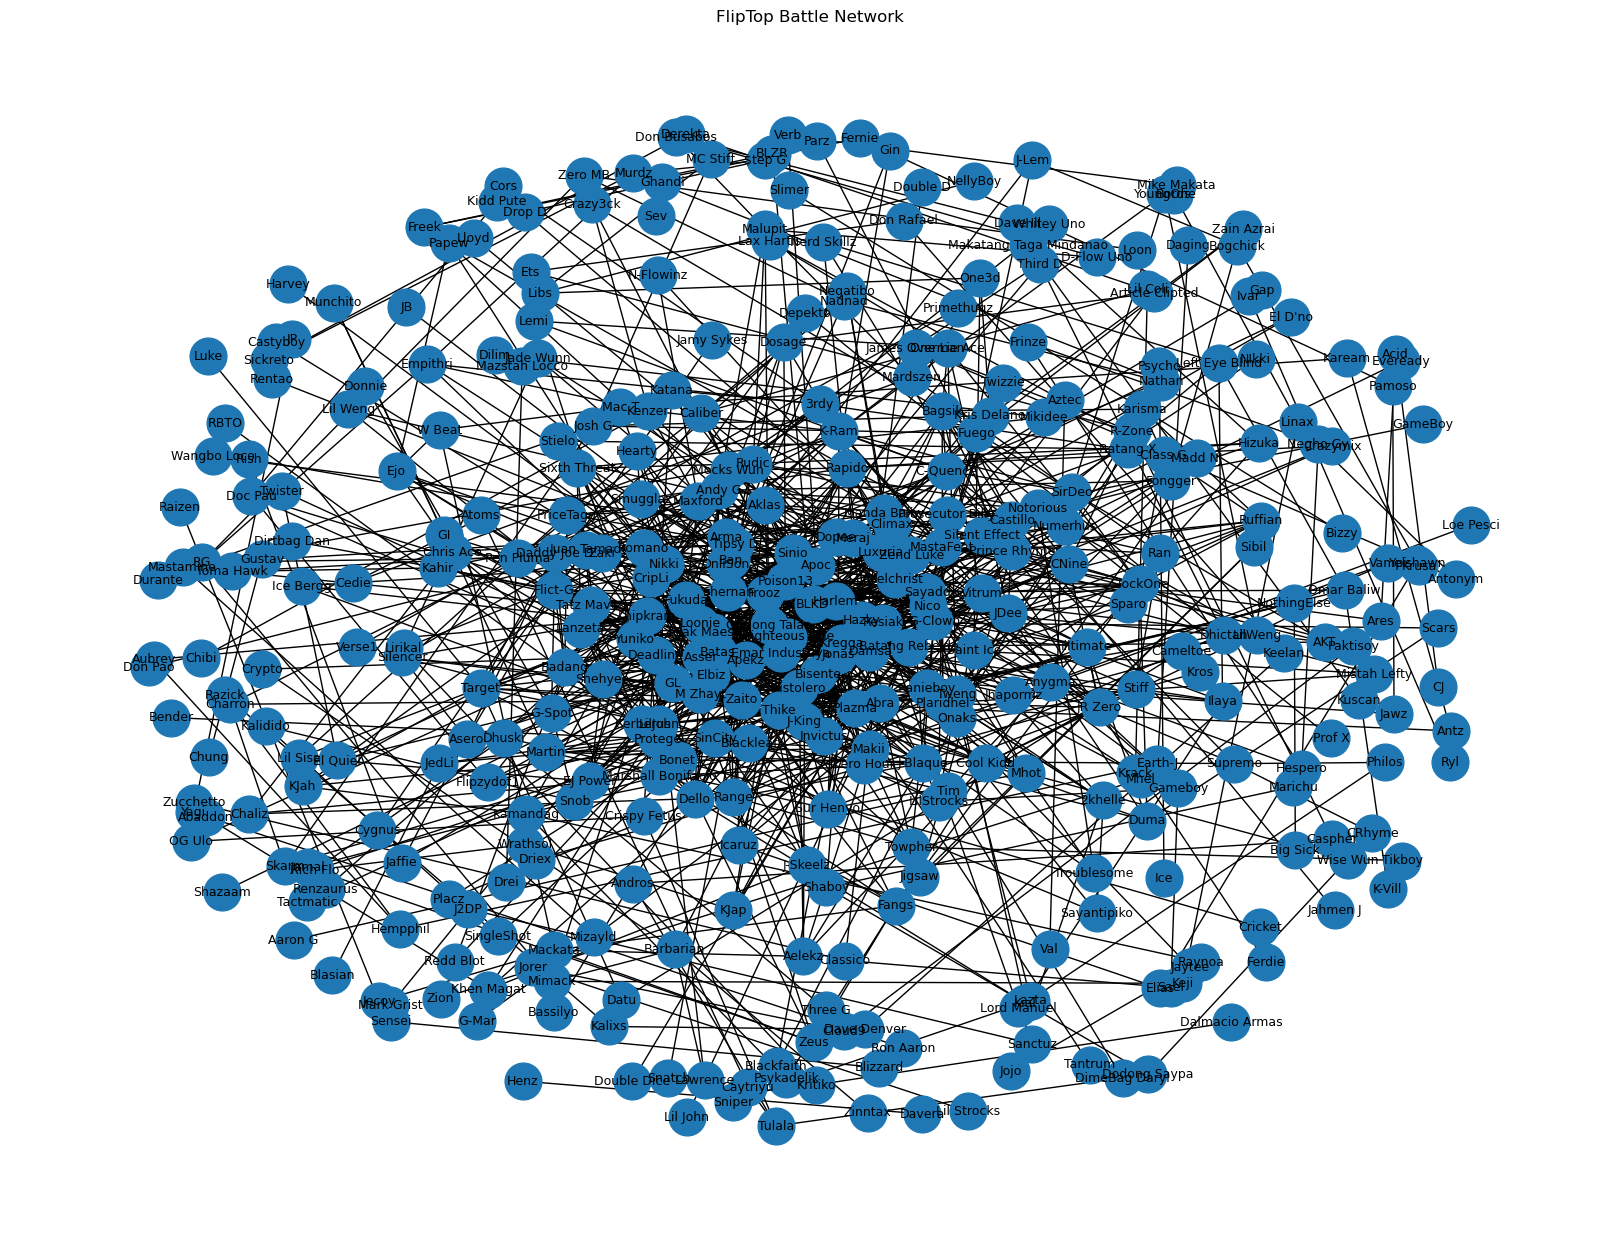

In [80]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.5)  # Force-directed layout
nx.draw(G, pos, with_labels=True, node_size=700, font_size=9)
plt.title("FlipTop Battle Network")
plt.show()

In [81]:
from pyvis.network import Network

net = Network(notebook=True)
net.from_nx(G)

# Disable physics to stop the jiggly/bouncy animation
net.set_options("""
{
  "physics": {
    "enabled": true,
    "stabilization": {
      "enabled": true,
      "iterations": 200,
      "updateInterval": 25
    },
    "barnesHut": {
      "gravitationalConstant": -30000,
      "centralGravity": 0.2,
      "springLength": 95,
      "springConstant": 0.04,
      "damping": 0.7,
      "avoidOverlap": 1
    }
  }
}
""")

 

# net.show("../data/fliptop_graph.html")

#### Basic Network Analysis

In [82]:
# Simple degree
degrees = dict(G.degree())

# Weighted degree (battle count)
weighted_degrees = dict(G.degree(weight='weight'))

In [83]:
degrees

{'CRhyme': 3,
 'Caspher': 3,
 'Hespero': 3,
 'Negho Gy': 3,
 'JP': 2,
 'Yagi': 2,
 'Emar Industriya': 12,
 'Poison13': 35,
 'Marichu': 1,
 'Shaboy': 3,
 'Murdz': 4,
 'Sickreto': 3,
 'Empithri': 6,
 'GI': 5,
 'Pen Pluma': 9,
 'J-King': 19,
 'Lhipkram': 24,
 'SlockOne': 15,
 'Luxuria': 12,
 'M Zhayt': 26,
 'CNine': 14,
 'Jonas': 27,
 'Apoc': 18,
 'Lanzeta': 15,
 'Kregga': 21,
 'Batas': 27,
 'Sak Maestro': 18,
 'Lil Weng': 2,
 'Yuniko': 10,
 'Abra': 12,
 'Invictus': 19,
 'Batang Rebelde': 27,
 'Plazma': 30,
 'Frooz': 26,
 'Harlem': 22,
 'Target': 12,
 'Thike': 20,
 'Tikboy': 1,
 'Towpher': 7,
 'Rapido': 16,
 'Silent Effect': 5,
 'Pistolero': 29,
 'Shehyee': 16,
 'Kris Delano': 11,
 'Prosecutor Billy': 8,
 'Blackleaf': 5,
 'Stielo': 2,
 'J-Skeelz': 5,
 'Daddy Joe D': 13,
 'Zaito': 31,
 'Caliber': 5,
 'Smugglaz': 9,
 'Maxford': 12,
 'Whitey Uno': 1,
 'Datu': 2,
 'JDee': 16,
 'Ruffian': 8,
 '3rdy': 6,
 'Katana': 5,
 'Ban': 5,
 'Manda Baliw': 9,
 'K-Ram': 15,
 'Kenzer': 6,
 'Zaki': 7,
 'Zend 

In [84]:
import networkx as nx

betweenness = nx.betweenness_centrality(G)
pagerank = nx.pagerank(G, weight='weight')

In [85]:
# Top 10 most emcees with the most battles
sorted_by_battles = (
    sorted(
        weighted_degrees.items(), key=lambda x: x[1], reverse=True
    )
)

sorted_by_battles[:10]

[('Poison13', 35),
 ('Zaito', 31),
 ('Goriong Talas', 31),
 ('Plazma', 30),
 ('Pistolero', 29),
 ('Sayadd', 29),
 ('Jonas', 27),
 ('Batas', 27),
 ('Batang Rebelde', 27),
 ('M Zhayt', 26)]

Poison13 has the most battles at 35. Wow. That's a lot. 

In [86]:
with_matches.dtypes

id                                 object
title                              object
description                        object
upload_date           datetime64[ns, UTC]
view_count                          int64
duration                           object
url                                object
likeCount                           int64
commentCount                        int64
tags                               object
duration_timedelta        timedelta64[ns]
duration_seconds                  float64
matchup                            object
emcee1                             object
emcee2                             object
emcee1_in_official                   bool
emcee2_in_official                   bool
matchup_clean                      object
dtype: object

### Career Analysis

In [87]:
import pandas as pd

def compute_career_span_by_months(df):
    # Combine encee1 and emcee2 into one long DF
    emcee_dates = pd.concat([
        df[["emcee1", "upload_date"]].rename(columns={"emcee1": "emcee"}),
        df[["emcee2", "upload_date"]].rename(columns={"emcee2": "emcee"})
    ])

    # Helper to compute diff in months
    def diff_in_months(start, end):
        return (end.year - start.year) * 12 + (end.month - start.month)
    

    def compute_gap_stats(emcee_dates):
        rows = []

        for emcee, group in emcee_dates.groupby("emcee"):
            dates = group["upload_date"].sort_values().reset_index(drop=True)

            if len(dates) < 2:
                rows.append({
                    "emcee": emcee,
                    "median_gap_months": None,
                    "mean_gap_months": None,
                    "stdev_gap_months": None
                })
                continue

            # Compute all gaps in months
            gaps = [
                diff_in_months(dates[i], dates[i+1]) for i in range(len(dates) - 1)
            ]

            gaps_series = pd.Series(gaps)

            rows.append({
                "emcee": emcee,
                "median_gap_months": gaps_series.median(),
                "mean_gap_months": gaps_series.mean(),
                "stdev_gap_months": gaps_series.std()
            })
        
        return pd.DataFrame(rows)

    # Group by emcee and compute first and last appearance, count, career length
    grouped = emcee_dates.groupby("emcee").agg(
        first_battle=("upload_date", "min"),
        last_battle=("upload_date", "max"),
        battle_count=("upload_date", "count")
    )
    
    # Compute career length in months
    grouped["career_length_months"] = (
        grouped.apply(
            lambda row: diff_in_months(row["first_battle"], row["last_battle"]), axis=1
        )
    )

    # Compute gap statistics
    gap_stats = compute_gap_stats(emcee_dates)

    # Join
    grouped = (
        grouped
        .reset_index()
        .merge(
            gap_stats, on="emcee", how="left"
        )
    )

    # Sort by career length
    grouped = grouped.sort_values("career_length_months", ascending=False)

    return grouped

In [88]:
career_summary = compute_career_span_by_months(with_matches)

In [89]:
career_summary.head(10)

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months
291,Plazma,2010-05-04 09:48:43+00:00,2025-04-24 12:38:52+00:00,30,179,5.0,6.172414,4.870237
143,Harlem,2010-08-21 08:42:09+00:00,2025-03-08 12:43:02+00:00,22,175,4.0,8.333333,9.172422
327,Sayadd,2011-01-28 15:10:01+00:00,2025-05-29 11:31:47+00:00,29,172,5.0,6.142857,3.217018
334,Shehyee,2010-09-07 08:55:08+00:00,2025-01-05 11:18:54+00:00,17,172,3.5,10.750000,18.968395
16,Apoc,2010-05-04 09:48:43+00:00,2024-05-23 12:37:39+00:00,18,168,10.0,9.882353,5.893666
141,Goriong Talas,2011-04-02 12:13:44+00:00,2025-03-27 12:52:22+00:00,31,167,4.5,5.566667,4.598975
324,Saint Ice,2011-12-16 09:29:59+00:00,2025-05-17 13:09:25+00:00,6,161,4.0,32.200000,62.547582
389,Zaito,2010-06-18 13:49:33+00:00,2023-09-23 12:54:16+00:00,31,159,4.0,5.300000,5.011366
342,Sinio,2012-01-14 11:00:46+00:00,2025-04-17 12:55:09+00:00,19,159,4.0,8.833333,11.052016
308,Rapido,2012-03-10 12:52:11+00:00,2025-05-12 13:06:54+00:00,17,158,4.0,9.875000,20.590856


Wow. The longevity on Plazma's career is crazy. He was there from the start in 2010 and still battles to this day, as of writing, in 2025. 15 years man.

In [90]:
career_summary.tail(10)

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months
382,Wise Wun,2016-05-25 10:45:25+00:00,2016-05-25 10:45:25+00:00,1,0,NaN,NaN,NaN
119,Eveready,2024-07-13 14:20:47+00:00,2024-07-13 14:20:47+00:00,1,0,NaN,NaN,NaN
121,Ferdie,2011-11-29 12:31:09+00:00,2011-11-29 12:31:09+00:00,1,0,NaN,NaN,NaN
22,Atoms,2024-10-13 07:30:20+00:00,2024-10-13 07:30:20+00:00,1,0,NaN,NaN,NaN
24,Aztec,2024-10-27 09:44:00+00:00,2024-10-27 09:44:00+00:00,1,0,NaN,NaN,NaN
31,Bassilyo,2012-10-10 12:24:50+00:00,2012-10-10 12:24:50+00:00,1,0,NaN,NaN,NaN
35,Bender,2013-06-24 11:12:54+00:00,2013-06-24 11:12:54+00:00,1,0,NaN,NaN,NaN
357,Tactmatic,2011-07-06 08:27:52+00:00,2011-07-06 08:27:52+00:00,1,0,NaN,NaN,NaN
358,Tantrum,2013-06-17 06:05:58+00:00,2013-06-17 06:05:58+00:00,1,0,NaN,NaN,NaN
363,Three G,2015-10-14 13:24:42+00:00,2015-10-14 13:24:42+00:00,1,0,NaN,NaN,NaN


These are the most short-lived FlipTop careers. They only ever battled once in the league. That's not to say they didn't do well in other leagues. Or if their careers were long-lived for other battle formats (like 2v2's) e.g. Basilyo. We don't know that.
- Another example is Bender. He is a battle rap legend from Canada. He came over to do a battle on FlipTop once. 

In [91]:
career_summary[career_summary["battle_count"] == 2].head(10)

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months
218,Lil Sisa,2011-05-04 09:07:35+00:00,2017-02-13 10:17:30+00:00,2,69,69.0,69.0,NaN
14,Anygma,2010-12-30 22:31:21+00:00,2013-06-19 11:33:06+00:00,2,30,30.0,30.0,NaN
375,Vampi,2017-07-15 07:16:15+00:00,2019-12-04 12:08:33+00:00,2,29,29.0,29.0,NaN
83,Dave Ill,2014-01-02 12:41:33+00:00,2016-01-28 10:46:13+00:00,2,24,24.0,24.0,NaN
165,JP,2023-08-09 12:43:28+00:00,2025-03-24 12:51:25+00:00,2,19,19.0,19.0,NaN
384,Yagi,2023-08-31 11:57:53+00:00,2025-03-24 12:51:25+00:00,2,19,19.0,19.0,NaN
88,Derekta,2023-08-17 12:41:54+00:00,2025-03-13 12:30:14+00:00,2,19,19.0,19.0,NaN
13,Antz,2011-12-07 13:08:01+00:00,2013-05-22 13:36:47+00:00,2,17,17.0,17.0,NaN
140,Gin,2012-01-25 00:13:30+00:00,2013-05-02 10:31:55+00:00,2,16,16.0,16.0,NaN
373,Twizzie,2012-04-14 13:36:31+00:00,2013-06-06 10:40:53+00:00,2,14,14.0,14.0,NaN


These are some of the people that only battled twice in their FlipTop careers. 

A metric I'm curious about is the average or median time between battles for each of the emcees.

In [92]:
career_summary.head(5)

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months
291,Plazma,2010-05-04 09:48:43+00:00,2025-04-24 12:38:52+00:00,30,179,5.0,6.172414,4.870237
143,Harlem,2010-08-21 08:42:09+00:00,2025-03-08 12:43:02+00:00,22,175,4.0,8.333333,9.172422
327,Sayadd,2011-01-28 15:10:01+00:00,2025-05-29 11:31:47+00:00,29,172,5.0,6.142857,3.217018
334,Shehyee,2010-09-07 08:55:08+00:00,2025-01-05 11:18:54+00:00,17,172,3.5,10.750000,18.968395
16,Apoc,2010-05-04 09:48:43+00:00,2024-05-23 12:37:39+00:00,18,168,10.0,9.882353,5.893666


In [93]:
career_summary.shape

(398, 8)

In [94]:
import pandas as pd

def annotate_inactivity(career_df, battles_df, fallback_months=24, buffer_months=6, today=None):
    """
    Annotates emcee career data with inactivity status and related diagnostics.

    Parameters:
        career_df (pd.DataFrame): Must include:
            - "last_battle" (datetime)
            - "battle_count" (int)
            - "median_gap_months" (float)
        battles_df (pd.DataFrame): Must include:
            - fallback_months (float): Used when an emcee has no median gap between battles
            - buffer_months (float): Grace period added to the median gap to define inactivity threshold
    Returns:
        pd.DataFrame: Copy of career_df with added columns:
            - "months_since_last_battle"
            - "inactivity_treshold_months"
            - "inactive" (0 or 1)
            - "status" (str)
            - "confidence" (float)
    """

    # Use latest upload date in battles_df as the effective "today"
    today = battles_df["upload_date"].max()


    # Compute months since last battle
    months_since_last = (
        (today.year - career_df["last_battle"].dt.year) * 12 + (today.month - career_df["last_battle"].dt.month)
    )

    # Define inactivity threshold = median gap + buffer
    median_gap = career_df["median_gap_months"].fillna(fallback_months)
    inactivity_threshold = median_gap + buffer_months

    # Inactive if months_since_last exceeds threshold
    is_inactive = (months_since_last > inactivity_threshold).astype(int)

    # Assign status labels for more flavor text and context to inactivity:
    def classify(row, recent_months=12):
        if row["battle_count"] == 1:
            months_since_first = row["months_since_last_battle"]
            if months_since_first <= recent_months:
                return "single-battle-active" # new emcee, has recent battle, but just debuted
            else:
                return "single-battle-inactive" if row["inactive"] else "single-battle-active"
        return "inactive" if row["inactive"] else "active"
    
    # Confidence score: ratio of time since last battle to expected gap
    confidence_score = months_since_last / median_gap

    # Putting it all together
    result = career_df.copy()
    result["months_since_last_battle"] = months_since_last
    result["inactivity_threshold_months"] = inactivity_threshold
    result["inactive"] = is_inactive
    result["status"] = result.apply(lambda row: classify(row, recent_months=12), axis=1)
    result["confidence"] = confidence_score.round(2)

    return result


In [95]:
careers = annotate_inactivity(career_df=career_summary, battles_df=with_matches)

In [96]:
careers.head()

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months,months_since_last_battle,inactivity_threshold_months,inactive,status,confidence
291,Plazma,2010-05-04 09:48:43+00:00,2025-04-24 12:38:52+00:00,30,179,5.0,6.172414,4.870237,3,11.0,0,active,0.60
143,Harlem,2010-08-21 08:42:09+00:00,2025-03-08 12:43:02+00:00,22,175,4.0,8.333333,9.172422,4,10.0,0,active,1.00
327,Sayadd,2011-01-28 15:10:01+00:00,2025-05-29 11:31:47+00:00,29,172,5.0,6.142857,3.217018,2,11.0,0,active,0.40
334,Shehyee,2010-09-07 08:55:08+00:00,2025-01-05 11:18:54+00:00,17,172,3.5,10.750000,18.968395,6,9.5,0,active,1.71
16,Apoc,2010-05-04 09:48:43+00:00,2024-05-23 12:37:39+00:00,18,168,10.0,9.882353,5.893666,14,16.0,0,active,1.40


In [97]:
careers.tail(10)

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months,months_since_last_battle,inactivity_threshold_months,inactive,status,confidence
382,Wise Wun,2016-05-25 10:45:25+00:00,2016-05-25 10:45:25+00:00,1,0,NaN,NaN,NaN,110,30.0,1,single-battle-inactive,4.58
119,Eveready,2024-07-13 14:20:47+00:00,2024-07-13 14:20:47+00:00,1,0,NaN,NaN,NaN,12,30.0,0,single-battle-active,0.50
121,Ferdie,2011-11-29 12:31:09+00:00,2011-11-29 12:31:09+00:00,1,0,NaN,NaN,NaN,164,30.0,1,single-battle-inactive,6.83
22,Atoms,2024-10-13 07:30:20+00:00,2024-10-13 07:30:20+00:00,1,0,NaN,NaN,NaN,9,30.0,0,single-battle-active,0.38
24,Aztec,2024-10-27 09:44:00+00:00,2024-10-27 09:44:00+00:00,1,0,NaN,NaN,NaN,9,30.0,0,single-battle-active,0.38
31,Bassilyo,2012-10-10 12:24:50+00:00,2012-10-10 12:24:50+00:00,1,0,NaN,NaN,NaN,153,30.0,1,single-battle-inactive,6.38
35,Bender,2013-06-24 11:12:54+00:00,2013-06-24 11:12:54+00:00,1,0,NaN,NaN,NaN,145,30.0,1,single-battle-inactive,6.04
357,Tactmatic,2011-07-06 08:27:52+00:00,2011-07-06 08:27:52+00:00,1,0,NaN,NaN,NaN,168,30.0,1,single-battle-inactive,7.00
358,Tantrum,2013-06-17 06:05:58+00:00,2013-06-17 06:05:58+00:00,1,0,NaN,NaN,NaN,145,30.0,1,single-battle-inactive,6.04
363,Three G,2015-10-14 13:24:42+00:00,2015-10-14 13:24:42+00:00,1,0,NaN,NaN,NaN,117,30.0,1,single-battle-inactive,4.88


Mind you that someone like Bassilyo is definitely inactive. And his battle_count is only 1 because we're only counting 1v1 rap battles in FlipTop.
- He was most active in his Dos Por Dos (2v2) tournament run.

#### Basic Survival Analysis

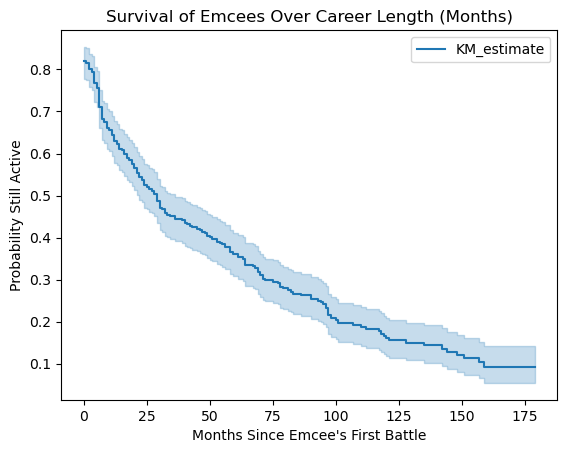

In [98]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

# Define survival data
T = careers["career_length_months"]
E = careers["inactive"]

# Fit and plot
kmf.fit(T, event_observed=E)
kmf.plot_survival_function()
plt.title("Survival of Emcees Over Career Length (Months)")
plt.xlabel("Months Since Emcee's First Battle")
plt.ylabel("Probability Still Active")
plt.grid=True
plt.show()

In [99]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def plot_km_curve(df, time_col="career_length_months", status_col="status"):
    # Initialize model
    kmf = KaplanMeierFitter()

    # Define duration and event observed
    durations = df[time_col]
    event_observed = df[status_col].isin(["inactive", "single-battle-inactive"])

    # Fit the model
    kmf.fit(durations, event_observed=event_observed)

    # Plot
    plt.figure(figsize=(10,6))
    ax = kmf.plot(ci_show=True)
    ax.set_title("Kaplan-Meier estimate of Emcee Career Duration")
    ax.set_xlabel("Months Since First Recorded Battle")
    ax.set_ylabel("Probability Emcee Remains Active")
    ax.set_xticks(
        range(0, int(durations.max()) + 12, 12) # Yearly intervals
    )
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [100]:
import matplotlib.pyplot as plt
import importlib
importlib.reload(plt)

<module 'matplotlib.pyplot' from 'c:\\Users\\rsl\\miniforge3\\envs\\fliptop-analysis\\Lib\\site-packages\\matplotlib\\pyplot.py'>

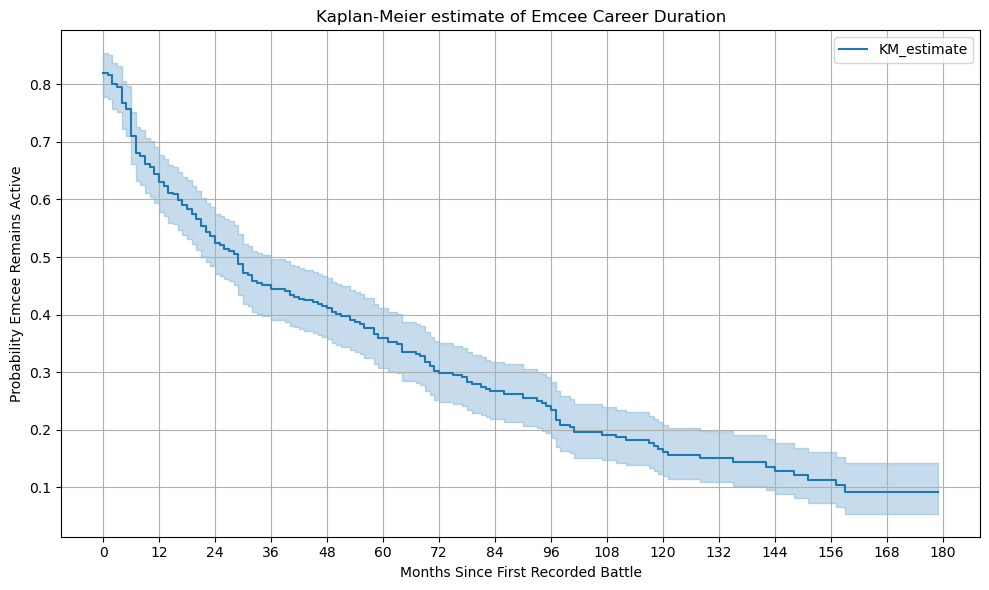

In [101]:
plot_km_curve(careers, time_col="career_length_months", status_col="status")

In [102]:
careers.head()

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months,months_since_last_battle,inactivity_threshold_months,inactive,status,confidence
291,Plazma,2010-05-04 09:48:43+00:00,2025-04-24 12:38:52+00:00,30,179,5.0,6.172414,4.870237,3,11.0,0,active,0.60
143,Harlem,2010-08-21 08:42:09+00:00,2025-03-08 12:43:02+00:00,22,175,4.0,8.333333,9.172422,4,10.0,0,active,1.00
327,Sayadd,2011-01-28 15:10:01+00:00,2025-05-29 11:31:47+00:00,29,172,5.0,6.142857,3.217018,2,11.0,0,active,0.40
334,Shehyee,2010-09-07 08:55:08+00:00,2025-01-05 11:18:54+00:00,17,172,3.5,10.750000,18.968395,6,9.5,0,active,1.71
16,Apoc,2010-05-04 09:48:43+00:00,2024-05-23 12:37:39+00:00,18,168,10.0,9.882353,5.893666,14,16.0,0,active,1.40


In [103]:
kmf.median_survival_time_

np.float64(29.0)

50% of all emcees stop doing 1v1 battling (i.e. become inactive) within 29 months of their debut.
- So more than 2 years after their debuts, 50% of emcees drop out of the game.

#### Emcee Career Survival Analysis: Documented Assumptions

1. Defining "Career Start" and "Career Length"

- A career starts at the date of an emcee's first recorded battle (`first_battle`).

- Career length is measured in months, computed as:
    `(last_battle.year - first_battle.year) * 12 + (last_battle.month - first_battle.month)`

2. Gap Statistics Between Battles

For each emcee, the following statistics are computed:
- `median_gap_months`: median time between consecutive battles
- `mean_gap_months`: average time between battles
- `stdev_gap_months`: standard deviation of gap durations

Gaps are measured in months, not days.

3. Defining Inactivity

An emcee is considered inactive if:
- Time since their last battle exceeds their `median_gap_months` plus a buffer of 6 months.
- If the emcee has only 1 battle, or their median gap is zero or missing, the fallback threshold is 24 months.

Explicit thresholds used:
- `fallback_months` = 24
- `buffer_months` = 6

Thus:
- `inactivity_threshold_months = median_gap_months + buffer_months`

4. Emcee Status Classification

Each emcee is assigned a status string for richer diagnostic context:
- `active`: More than one battle and last battle was recent
- `inactive`: More than one battle and last battle was too long ago
- `single-battle-active`: Only one battle, but still recent
- `single-battle-inactive`: Only one battle, and too long ago
- `unknown`: Missing or malformed battle date information

Additionally, a binary inactive column is defined as 1 or 0 based on the threshold logic.


5. Pandemic-Aware Buffering
- The choice of `fallback_months` = 24 is intentionally generous to account for disruption in recorded battles during the COVID-19 pandemic (approximately 2020–2023).
- This helps avoid misclassifying emcees as inactive if their last battle occurred just before or during the pandemic.

6. Survival Analysis Assumptions

- An emcee is considered to have had a career-ending event if their status is either `inactive` or `single-battle-inactive`.
- Emcees with other statuses (`active`, `single-battle-active`, `unknown`) are treated as right-censored in the Kaplan-Meier analysis.
- The survival curve shows the probability that an emcee remains active (not yet inactive) over time in months since their first battle.
- A median survival time of 29 months means that half of emcees remain active at least 29 months into their career.

In [104]:
careers.head()

,emcee,first_battle,last_battle,battle_count,career_length_months,median_gap_months,mean_gap_months,stdev_gap_months,months_since_last_battle,inactivity_threshold_months,inactive,status,confidence
291,Plazma,2010-05-04 09:48:43+00:00,2025-04-24 12:38:52+00:00,30,179,5.0,6.172414,4.870237,3,11.0,0,active,0.60
143,Harlem,2010-08-21 08:42:09+00:00,2025-03-08 12:43:02+00:00,22,175,4.0,8.333333,9.172422,4,10.0,0,active,1.00
327,Sayadd,2011-01-28 15:10:01+00:00,2025-05-29 11:31:47+00:00,29,172,5.0,6.142857,3.217018,2,11.0,0,active,0.40
334,Shehyee,2010-09-07 08:55:08+00:00,2025-01-05 11:18:54+00:00,17,172,3.5,10.750000,18.968395,6,9.5,0,active,1.71
16,Apoc,2010-05-04 09:48:43+00:00,2024-05-23 12:37:39+00:00,18,168,10.0,9.882353,5.893666,14,16.0,0,active,1.40
